In [113]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report
from csv import writer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
import matplotlib.pyplot as plt
import time

**Cluster Similar Attributes**

In [114]:
designation_grp = [['officer'],
                   ['prof','adj_prof','vis_prof'],
                   ['stu']
                  ]


type_grp = [['asgn','quiz'],
            ['off_rec','dept_bud','proj'],
            ['std_mat'],
            ['attdn','stu_rec'],
            ['q_pr','grade_book']
            ]

attr_grp={}
attr_grp['Designation'] = designation_grp
attr_grp['Type'] = type_grp

**Mapping**

In [115]:

def GetAttributeMapping(data,grp=None,grp_gap=20,map_type=1):
    #print('in mapping')
    #print(data)
    #for col in data.columns[:7]:
    #        print(col,data[col].unique())
    mapping = {}
    mapping['NotA'] = -1
    mapping[0] = 0
    #mapping[1] = 1
    mapping['Yes'] = 1
    mapping['No'] = 0
    if(map_type==1):
        for col in data.columns[:7]:
            #print(col,data[col].unique())
            col_un = data[col].unique()
            cnt = 1
            for val in col_un:
                if(val != 'NotA'):
                    mapping[val] = cnt
                    cnt = cnt + 1
        print(mapping)
        return mapping
    elif(map_type==2):
        for col in data.columns[2:6]:
            col_un = data[col].unique()
            cnt = 1
            for val in col_un:
                if(val != 'NotA'):
                    mapping[val] = cnt
                    cnt = cnt + 1
        
        for g in grp:
            grp_num = 1
            for member in grp[g]:
                mem_num = 1
                for val in member:
                    mapping[val] = grp_num*grp_gap+mem_num
                    mem_num = mem_num + 1
                grp_num = grp_num + 1
        print(mapping)
        return mapping
        
  

In [116]:
def same_conditions(col1,col2):
    if ((col1 == -1) or (col2 == -1)):
        return 2
    elif (col1==col2):
        return 1
    else:
        return 0

def chk_nota(col):
    if(col==-1):
        return 1
    else:
        return 0

**Encoding the Test and Train Points**

In [117]:
def GetPreparedData(train_data,test_data,prep_type=4):
    #print('in prepare data')
    data = pd.concat([train_data,test_data],axis=0)
    if(prep_type==1):#Naive
        map_type = 1
        mapping = GetAttributeMapping(data,grp=attr_grp,map_type=map_type)
        #print(mapping)
        data_encoded = data.replace(mapping)
    elif(prep_type==2):#Columns for same attribute values in subject and object
        map_type = 1
        mapping = GetAttributeMapping(data,grp=attr_grp,map_type=map_type)
        data_encoded = data.replace(mapping)
        data_encoded['sameDep'] = data_encoded.apply(lambda x: same_conditions(x['Department'], x['Department.1']), axis=1)
        data_encoded['sameDeg'] = data_encoded.apply(lambda x: same_conditions(x['Degree'], x['Degree.1']), axis=1)
        data_encoded['sameYr'] = data_encoded.apply(lambda x: same_conditions(x['Year'], x['Year.1']), axis=1)
        data_encoded = data_encoded.drop('Department',axis=1)
        data_encoded = data_encoded.drop('Department.1',axis=1)
        data_encoded = data_encoded.drop('Degree',axis=1)
        data_encoded = data_encoded.drop('Degree.1',axis=1)
        data_encoded = data_encoded.drop('Year',axis=1)
        data_encoded = data_encoded.drop('Year.1',axis=1)
    elif(prep_type==3):#Grouping of attributes
        map_type = 2
        mapping = GetAttributeMapping(data,grp=attr_grp,map_type=map_type)
        data_encoded = data.replace(mapping)
    elif(prep_type==4):#Grouping of attributes + Columns for same attribute values in subject and object
        map_type = 2
        mapping = GetAttributeMapping(data,grp=attr_grp,map_type=map_type)
        data_encoded = data.replace(mapping)
        data_encoded['sameDep'] = data_encoded.apply(lambda x: same_conditions(x['Department'], x['Department.1']), axis=1)
        data_encoded['sameDeg'] = data_encoded.apply(lambda x: same_conditions(x['Degree'], x['Degree.1']), axis=1)
        data_encoded['sameYr'] = data_encoded.apply(lambda x: same_conditions(x['Year'], x['Year.1']), axis=1)
        data_encoded = data_encoded.drop('Department',axis=1)
        data_encoded = data_encoded.drop('Department.1',axis=1)
        data_encoded = data_encoded.drop('Degree',axis=1)
        data_encoded = data_encoded.drop('Degree.1',axis=1)
        data_encoded = data_encoded.drop('Year',axis=1)
        data_encoded = data_encoded.drop('Year.1',axis=1)
    elif(prep_type==5):#Naive+NACol
        map_type = 1
        mapping = GetAttributeMapping(data,grp=attr_grp,map_type=map_type)
        data_encoded = data.replace(mapping)
        data_encoded['Year_NA'] = data_encoded.apply(lambda x: chk_nota(x['Year']), axis=1)
        data_encoded['Year.1_NA'] = data_encoded.apply(lambda x: chk_nota(x['Year.1']), axis=1)
        data_encoded['Degree_NA'] = data_encoded.apply(lambda x: chk_nota(x['Degree']), axis=1)
        data_encoded['Degree.1_NA'] = data_encoded.apply(lambda x: chk_nota(x['Degree.1']), axis=1)
    
    X = data_encoded.loc[:, data_encoded.columns != 'Access']
    y = data_encoded.loc[:, data_encoded.columns == 'Access']
    
    X_train = X.head(train_data.shape[0])
    X_test = X.tail(test_data.shape[0])
    y_train = y.head(train_data.shape[0])
    y_test = y.tail(test_data.shape[0])
    #print(X)
    return X_train, X_test, y_train, y_test

In [118]:
def score(Ytest, pred, label, clfname, fname):
    acc = accuracy_score(Ytest, pred)
    pre = precision_score(Ytest, pred)
    rec = recall_score(Ytest, pred)
    f1 = f1_score(Ytest, pred)
    print(f"{label}:\naccuracy: {acc:.2f}\nprecision: {pre:.2f}\nrecall: {rec:.2f}\nfscore: {f1:.2f}\n")
    #scores = [str(clfname),str(label),str(acc),str(pre),str(rec),str(f1)]
    #file_name = './results_new/' + fname + '.csv'
    f = open(fname, "a+")
    #f.write('%s,%s,%0.3f,%f,%f,%f\n' % (clfname,label,acc,pre,rec,f1))
    f.write('%0.3f,%0.3f,%0.3f,%0.3f,' % (acc,pre,rec,f1))
    f.close()
        
    

def find_misclassifications(Ytest, pred, test_data, fname):
    misclassifications = test_data[Ytest['Access'] != pred["Access"]]
    misclassifications.to_csv(fname, index=False)
    return misclassifications

**Models Used**

In [119]:

models_dict = {
    #"SupportVectorMachine": SVC(kernel="linear"),
    #"LogisticRegression": LogisticRegression(solver="saga", n_jobs=-1),
    "ArtificalNeuralNetwork": MLPClassifier(hidden_layer_sizes=30, max_iter=1500,random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    #"ExtraTree": ExtraTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_jobs=-1,random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_jobs=-1,random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="error", n_jobs=-1,random_state=42),
    #"LightGBM": LGBMClassifier(n_estimators=100, n_jobs=-1),
    #"AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=1.0),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,random_state=42),
}

**Finding the Misclassifications and Labeling the misclassifications to make Decision Trees with dot files**

In [120]:


from numpy import rec
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

def do_testing(file_name,testfile,trainfile,pick=False):
    f = open(file_name+".csv", "w+")
    f.write('clf_name,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,\n')
    f.close()

    if(True):
        name = "Decision Tree"
        clf = DecisionTreeClassifier(random_state=42)
        print(f"[INFO] Training model: {name}")
        f = open(file_name+".csv", "a+")
        f.write('%s,' % (name))
        f.close()

        for i in range(4,5): 
            print(i)
            
            train_data = pd.read_csv(trainfile)
            test_data = pd.read_csv(testfile)
            #print(train_data)
            #print(test_data)
            dataprep_start_time = time.time()
            X_train, X_test, y_train, y_test = GetPreparedData(train_data,test_data,prep_type=i)
            
            #print('Training the classifier')
            if(not pick):
                clf = clf.fit(X_train.to_numpy(), y_train.to_numpy())
            else:
                with open('dt.pkl', 'rb') as f:
                    clf = pickle.load(f)
            
            pred = clf.predict(X_test.to_numpy())
            test_end_time = time.time()
            # print(classification_report(y_test.to_numpy(), pred))
            # print('Data_preptime=%f' %(train_start_time-dataprep_start_time))
            # print('Training_time=%f' %(train_end_time-train_start_time))
            # print('Testing_time=%f' %(test_end_time-train_end_time))
            
            score(y_test.to_numpy(), pred, label=str(i),clfname=name,fname=file_name+".csv")
            pred_train = clf.predict(X_train.to_numpy())
            
            pred = pd.DataFrame(pred,columns=['Access'])
            
            # print(pred, y_test)
            # print("test_data",test_data)

            # print("-"*60)
            #save DT to a figure
            from sklearn.tree import export_graphviz
            # print(type(X_test))
            misclass = find_misclassifications(y_test, pred, test_data, f'{file_name}_misclassifications_{i}.csv')
            #Make confusion matrix plot
            cm = confusion_matrix(y_test, pred)
            plt.figure(figsize=(10,7))
            sns.heatmap(cm, annot=True, fmt="d")
            plt.xlabel('Predicted')
            plt.ylabel('Truth')
            plt.title('Confusion Matrix')
            #make it color only leaf nodes
            dot_data = export_graphviz(clf, out_file=f'tree{i}.dot', feature_names = X_train.columns, rounded=True,filled=True, special_characters=True,leaves_parallel=True)
            
            #make tree to json
            
            #pickle this model
            with open(f'dt.pkl', 'wb') as f:
                pickle.dump(clf, f)
            
            X_train, X_test, y_train, y_test = GetPreparedData(train_data,misclass,prep_type=i)
            
            #print paths of misclassifications
    
            leaf_ids = clf.apply(X_test.to_numpy())
            print(leaf_ids)
            # find these indices in the tree
            with open(f"tree{i}.dot", 'r') as file:
                lines = file.readlines()
            
            #make a dict of leaf_ids to count of times it came in leaf_ids
            leaf_count = {}
            for leaf_id in leaf_ids:
                if leaf_id in leaf_count:
                    leaf_count[leaf_id] += 1
                else:
                    leaf_count[leaf_id] = 1
            for leaf_id, count in leaf_count.items():
                for ind,line in enumerate(lines):
                    if line.startswith(f'{leaf_id} [label=<gini'):
                        lines[ind] = line.replace(f'{leaf_id} [label=<gini', f'{leaf_id} [label=<Count={count} gini')
                        print(lines[ind])
                        break
                    
            with open(f"tree{i}_{file_name}.dot", 'w') as file:
                file.writelines(lines)

[INFO] Training model: Decision Tree
4
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'btech': 1, 'mtech': 2, 'BE': 3, 'ME': 4, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 81, 'off_rec': 41, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'grade_book': 102, 'std_mat': 61, 'proj': 43, 'dept_bud': 42, 'quiz': 22, 'ce': 1, 'accounts': 2, 'ece': 3, 'me': 4, 'cse': 5, 'chem': 6, 'eni': 7, 'IT': 8, 'pha': 9, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61}
4:
accuracy: 0.99
precision: 0.99
recall: 1.00
fscore: 0.99

{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'btech': 1, 'mtech': 2, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 81, 'off_rec': 41, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'grade_book': 102, 'std_mat': 61, 'dept_bud': 42, 'ce': 1, 'accounts': 2, 'ece': 3, 'me': 4, 'cse': 5, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61, 'quiz': 22, 'proj': 43}


C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


[ 4 21 21]
4 [label=<Count=1 gini = 0.0<br/>samples = 100<br/>value = [100, 0]>, fillcolor="#e58139"] ;

21 [label=<Count=2 gini = 0.0<br/>samples = 76<br/>value = [0, 76]>, fillcolor="#399de5"] ;



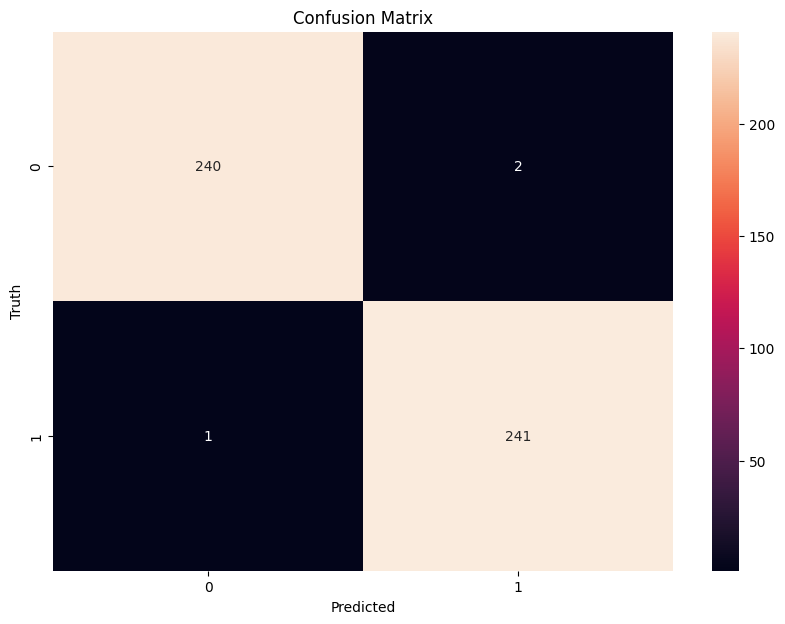

In [121]:
do_testing('change1','university1_c1.csv','university_saptarshi_train.csv')
#three msiclassifications

[INFO] Training model: Decision Tree
4
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'btech': 1, 'mtech': 2, 'BE': 3, 'ME': 4, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 81, 'off_rec': 41, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'grade_book': 102, 'std_mat': 61, 'quiz': 22, 'proj': 43, 'dept_bud': 42, 'ce': 1, 'accounts': 2, 'ece': 3, 'me': 4, 'cse': 5, 'chem': 6, 'pha': 7, 'eni': 8, 'IT': 9, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61}
4:
accuracy: 0.81
precision: 0.83
recall: 0.79
fscore: 0.81

{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'btech': 1, 'mtech': 2, 'BE': 3, 'ME': 4, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 81, 'off_rec': 41, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'grade_book': 102, 'std_mat': 61, 'ce': 1, 'accounts': 2, 'ece': 3, 'me': 4, 'cse': 5, 'chem': 6, 'eni': 7, 'pha': 8, 'IT': 9, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61, 'quiz': 22, 'dept_bud': 42, 'proj': 43}

C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)



[22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9]
22 [label=<Count=52 gini = 0.0<br/>samples = 547<br/>value = [547, 0]>, fillcolor="#e58139"] ;

9 [label=<Count=40 gini = 0.0<br/>samples = 213<br/>value = [0, 213]>, fillcolor="#399de5"] ;



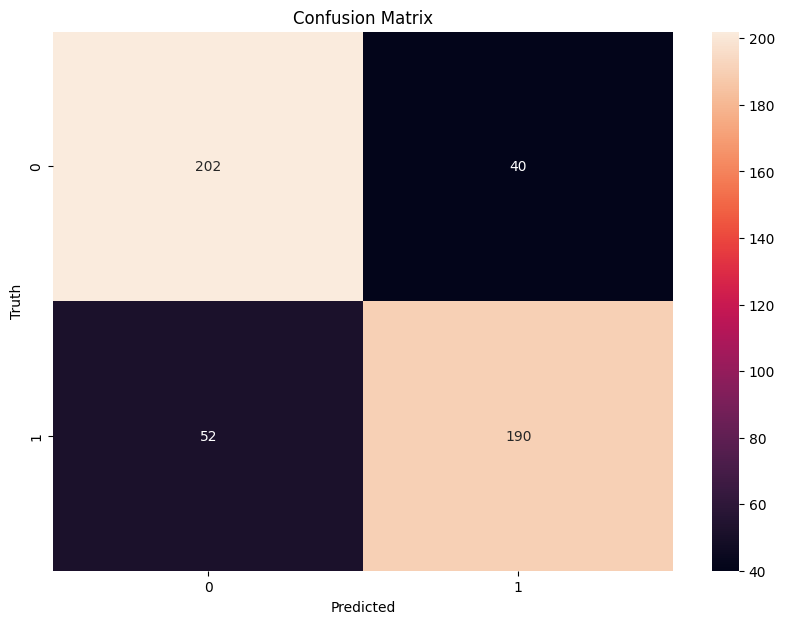

In [122]:
do_testing('change2','university1_c2.csv','university_saptarshi_train.csv',False)


[INFO] Training model: Decision Tree
4
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'btech': 1, 'mtech': 2, 'BE': 3, 'ME': 4, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 81, 'off_rec': 41, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'grade_book': 102, 'std_mat': 61, 'dept_bud': 42, 'proj': 43, 'quiz': 22, 'ce': 1, 'accounts': 2, 'ece': 3, 'me': 4, 'cse': 5, 'eni': 6, 'IT': 7, 'pha': 8, 'chem': 9, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61}
4:
accuracy: 0.89
precision: 0.82
recall: 1.00
fscore: 0.90



C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'btech': 1, 'mtech': 2, 'BE': 3, 'ME': 4, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 81, 'off_rec': 41, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'grade_book': 102, 'std_mat': 61, 'ce': 1, 'accounts': 2, 'ece': 3, 'me': 4, 'cse': 5, 'pha': 6, 'IT': 7, 'eni': 8, 'chem': 9, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61, 'quiz': 22, 'dept_bud': 42, 'proj': 43}
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
9 [label=<Count=53 gini = 0.0<br/>samples = 213<br/>value = [0, 213]>, fillcolor="#399de5"] ;



C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


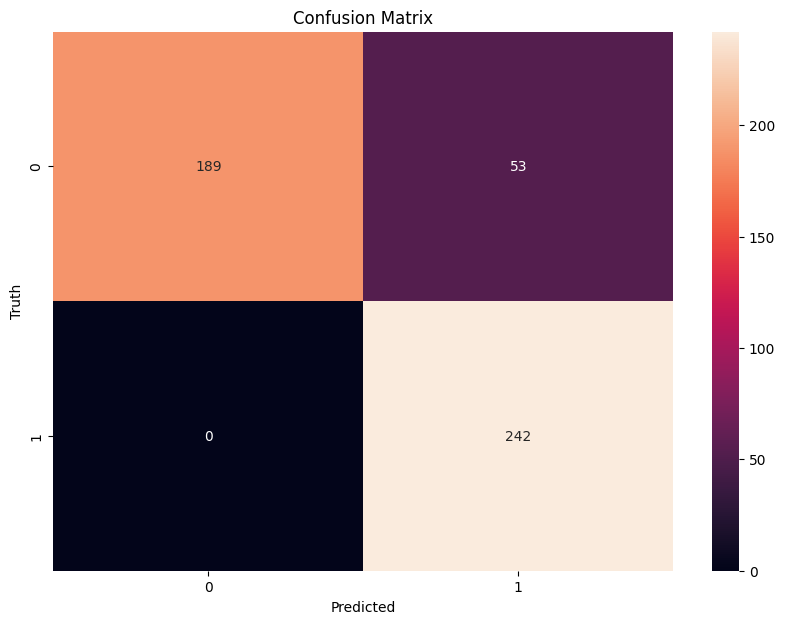

In [123]:
do_testing('change3','university1_c3.csv','university_saptarshi_train.csv',False)

****Finding the nearest neighbors of the misclassified points with train points <Hamming distance>****

In [124]:
def mahalanobis_distance(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left_term, x_mu.T)
    return mahal



def trainfortest(testfile,trainfile):
    """Find neearest nearest train points for train points, hamming distance"""
    test_data = pd.read_csv(testfile)
    print(test_data.size)
    print(test_data.shape)
    #copy these
    test_dat = pd.read_csv(testfile)
    train_data = pd.read_csv(trainfile)
    train_dat = pd.read_csv(trainfile)
    
    X_train, X_test, y_train, y_test = GetPreparedData(train_dat,test_dat,prep_type=1)
    
    
    min_ham = pd.DataFrame(columns = X_train.columns)
    print(X_test.shape)
    print(test_data.shape)
    for i in range(X_test.shape[0]):
        cov = np.cov(X_train.T)
        dist = mahalanobis_distance(X_test.iloc[i],X_train,cov)
        min_ham = min_ham._append(train_data.iloc[np.argmin(dist)],ignore_index=True)
    min_ham.reset_index(drop=True, inplace=True)
    print(min_ham)
    print(test_data.shape)
    test_data = test_data.join(min_ham, how='outer', rsuffix='_train')
    test_data.to_csv(testfile,index=False)
    #append these columns to the test_data
    #replace names of columns in min_ham to train columns
        
trainfortest('change1_misclassifications_4.csv','university_saptarshi_train.csv')
trainfortest('change2_misclassifications_4.csv','university_saptarshi_train.csv')
trainfortest('change3_misclassifications_4.csv','university_saptarshi_train.csv')


        
    

27
(3, 9)
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'stu': 1, 'prof': 2, 'officer': 3, 'ece': 3, 'me': 4, 'cse': 5, 'ce': 1, 'accounts': 2, 'btech': 2, 'mtech': 1, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 1, 'off_rec': 2, 'asgn': 3, 'q_pr': 4, 'stu_rec': 5, 'grade_book': 6, 'std_mat': 7, 'dept_bud': 8}
(3, 8)
(3, 9)
  Designation Department Degree Year   Type Department.1 Degree.1 Year.1  \
0         stu        ece  btech    2  attdn           ce    mtech      2   
1         stu        ece  btech    2  attdn           ce    mtech      2   
2         stu        ece  btech    2  attdn           ce    mtech      2   

  Access  
0     No  
1     No  
2     No  
(3, 9)
828
(92, 9)
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'stu': 1, 'prof': 2, 'officer': 3, 'vis_prof': 4, 'adj_prof': 5, 'ece': 3, 'me': 4, 'cse': 5, 'ce': 1, 'accounts': 2, 'chem': 6, 'eni': 7, 'pha': 8, 'IT': 9, 'btech': 2, 'mtech': 1, 'BE': 3, 'ME': 4, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 1, 'off_rec': 2, 'asgn': 3, 'q_pr': 4, 

C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


   Designation Department Degree Year   Type Department.1 Degree.1 Year.1  \
0          stu        ece  btech    2  attdn           ce    mtech      2   
1          stu        ece  btech    2  attdn           ce    mtech      2   
2          stu        ece  btech    2  attdn           ce    mtech      2   
3          stu        ece  btech    2  attdn           ce    mtech      2   
4          stu        ece  btech    2  attdn           ce    mtech      2   
..         ...        ...    ...  ...    ...          ...      ...    ...   
87         stu        ece  btech    2  attdn           ce    mtech      2   
88         stu        ece  btech    2  attdn           ce    mtech      2   
89         stu        ece  btech    2  attdn           ce    mtech      2   
90         stu        ece  btech    2  attdn           ce    mtech      2   
91         stu        ece  btech    2  attdn           ce    mtech      2   

   Access  
0      No  
1      No  
2      No  
3      No  
4      No  
.. 

C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


****Clustering the Change1,Change2,Change3 using K-Means with Hamming distance****

In [125]:
from sklearn.cluster import KMeans, DBSCAN

def cluster(file1,file2,file3):
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    
    #get prepared data
    X1,_,_,_ = GetPreparedData(data1,data1,prep_type=4)
    X2,_,_,_ = GetPreparedData(data2,data2,prep_type=4)
    X3,_,_,_ = GetPreparedData(data3,data3,prep_type=4)
    
    joined_data = pd.concat([X1,X2,X3],axis=0)
    print(joined_data.shape)
    #cluster this data
    kmeans = KMeans(n_clusters=6, random_state=42).fit(joined_data)
    #Label points vs dataset
    labels = kmeans.labels_
    #find number of points of X1,X2,X3 in each cluster
    kmeans_data = pd.DataFrame(labels,columns=['Cluster'])
    #Dataset column for 1 2 3
    kmeans_data['Dataset'] = 0
    kmeans_data.loc[0:X1.shape[0],'Dataset'] = 1
    kmeans_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    kmeans_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    joined_data = pd.concat([data1,data2,data3],axis=0)
    joined_data = joined_data.reset_index(drop=True)
    kmeans_data = kmeans_data.join(joined_data, how='outer')
    kmeans_data.to_csv('kmeans_data.csv',index=False)
    
    
cluster('university1_c1.csv','university1_c2.csv','university1_c3.csv')

    

{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'BE': 1, 'btech': 2, 'mtech': 3, 'ME': 4, '2': 1, '3': 2, '1': 3, '4': 4, 'std_mat': 61, 'attdn': 81, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'proj': 43, 'dept_bud': 42, 'quiz': 22, 'chem': 1, 'ece': 2, 'eni': 3, 'IT': 4, 'cse': 5, 'me': 6, 'ce': 7, 'pha': 8, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61, 'off_rec': 41, 'grade_book': 102}
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'BE': 1, 'ME': 2, 'mtech': 3, '3': 1, '1': 2, '4': 3, '2': 4, 'std_mat': 61, 'quiz': 22, 'attdn': 81, 'asgn': 21, 'proj': 43, 'q_pr': 101, 'stu_rec': 82, 'dept_bud': 42, 'grade_book': 102, 'chem': 1, 'pha': 2, 'eni': 3, 'IT': 4, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61, 'off_rec': 41}
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'BE': 1, 'ME': 2, 'mtech': 3, '1': 1, '4': 2, '2': 3, '3': 4, 'dept_bud': 42, 'std_mat': 61, 'stu_rec': 82, 'proj': 43, 'attdn': 81, 'asgn': 21, 'quiz': 22, 'q_pr': 101, 'grade_book': 102, 'eni': 1, 'IT': 2, 

C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


(1452, 5)


C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


In [126]:
k_data = pd.read_csv('kmeans_data.csv')
#Count of each cluster for each dataset
print(k_data.groupby(['Dataset','Cluster']).size())


Dataset  Cluster
1        0           86
         1           23
         2           43
         3           19
         4          237
         5           76
2        0          121
         1          123
         2          109
         3           59
         5           72
3        0           79
         1          118
         2           80
         3          154
         4           19
         5           34
dtype: int64


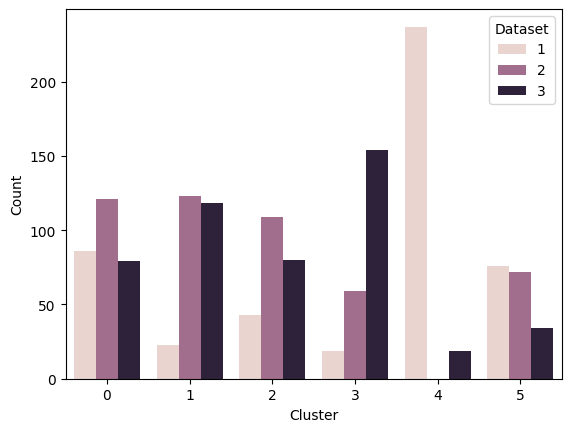

In [144]:
#plot the labels vs dataset
import matplotlib.pyplot as plt
import seaborn as sns

label_count = k_data.groupby(['Dataset','Cluster']).size().reset_index(name='Count')
label_count.to_csv('Kmeans_CLUSTERvsDATASET.csv',index=False)
sns.barplot(x='Cluster',y='Count',hue='Dataset',data=label_count)
plt.savefig('kmeans_plot.png')
plt.show()



We can see so much overlap between all the clusters and the points are not linearly separable. So, we can't use linear models to classify the points.

****Using DBSCAN to do the clustering****

{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'BE': 1, 'btech': 2, 'mtech': 3, 'ME': 4, '2': 1, '3': 2, '1': 3, '4': 4, 'std_mat': 61, 'attdn': 81, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'proj': 43, 'dept_bud': 42, 'quiz': 22, 'chem': 1, 'ece': 2, 'eni': 3, 'IT': 4, 'cse': 5, 'me': 6, 'ce': 7, 'pha': 8, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61, 'off_rec': 41, 'grade_book': 102}
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'BE': 1, 'ME': 2, 'mtech': 3, '3': 1, '1': 2, '4': 3, '2': 4, 'std_mat': 61, 'quiz': 22, 'attdn': 81, 'asgn': 21, 'proj': 43, 'q_pr': 101, 'stu_rec': 82, 'dept_bud': 42, 'grade_book': 102, 'chem': 1, 'pha': 2, 'eni': 3, 'IT': 4, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61, 'off_rec': 41}
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'BE': 1, 'ME': 2, 'mtech': 3, '1': 1, '4': 2, '2': 3, '3': 4, 'dept_bud': 42, 'std_mat': 61, 'stu_rec': 82, 'proj': 43, 'attdn': 81, 'asgn': 21, 'quiz': 22, 'q_pr': 101, 'grade_book': 102, 'eni': 1, 'IT': 2, 

C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_obje

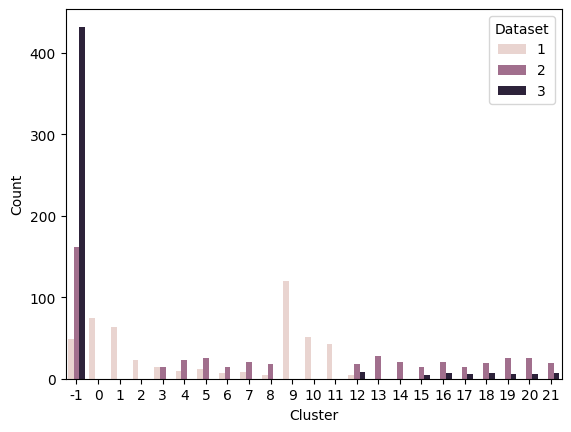

In [143]:

def cluster_dbscan(file1,file2,file3):
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    
    #get prepared data
    X1,_,_,_ = GetPreparedData(data1,data1,prep_type=4)
    X2,_,_,_ = GetPreparedData(data2,data2,prep_type=4)
    X3,_,_,_ = GetPreparedData(data3,data3,prep_type=4)
    
    joined_data = pd.concat([X1,X2,X3],axis=0)
    print(joined_data.shape)
    #cluster this data
    dbscan = DBSCAN(eps=0.5, min_samples=20).fit(joined_data)
    #Label points vs dataset
    labels = dbscan.labels_
    #find number of points of X1,X2,X3 in each cluster
    dbscan_data = pd.DataFrame(labels,columns=['Cluster'])
    #Dataset column for 1 2 3
    dbscan_data['Dataset'] = 0
    dbscan_data.loc[0:X1.shape[0],'Dataset'] = 1
    dbscan_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    dbscan_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    joined_data = pd.concat([data1,data2,data3],axis=0)
    joined_data = joined_data.reset_index(drop=True)
    dbscan_data = dbscan_data.join(joined_data, how='outer')
    dbscan_data.to_csv('dbscan_data.csv',index=False)

cluster_dbscan('university1_c1.csv','university1_c2.csv','university1_c3.csv')

d_data = pd.read_csv('dbscan_data.csv')
#Count of each cluster for each dataset
label_count = (d_data.groupby(['Dataset','Cluster']).size()).reset_index(name='Count')
label_count.to_csv("DSCAN_CLUSTERvsDATASET.csv",index=False)
sns.barplot(x='Cluster',y='Count',hue='Dataset',data=label_count)
plt.savefig('dbscan.png')
plt.show()



We can see that the points have somewhat been seperated with DBSCAN because they might be linear seperable in higher dimensions.But with hamming distance, we can see there is still overlap between the clusters.

****Using Mahalanobis Distance to Cluster with DBSCAN****

{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'BE': 1, 'btech': 2, 'mtech': 3, 'ME': 4, '2': 1, '3': 2, '1': 3, '4': 4, 'std_mat': 61, 'attdn': 81, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'proj': 43, 'dept_bud': 42, 'quiz': 22, 'chem': 1, 'ece': 2, 'eni': 3, 'IT': 4, 'cse': 5, 'me': 6, 'ce': 7, 'pha': 8, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61, 'off_rec': 41, 'grade_book': 102}
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'BE': 1, 'ME': 2, 'mtech': 3, '3': 1, '1': 2, '4': 3, '2': 4, 'std_mat': 61, 'quiz': 22, 'attdn': 81, 'asgn': 21, 'proj': 43, 'q_pr': 101, 'stu_rec': 82, 'dept_bud': 42, 'grade_book': 102, 'chem': 1, 'pha': 2, 'eni': 3, 'IT': 4, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61, 'off_rec': 41}
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'BE': 1, 'ME': 2, 'mtech': 3, '1': 1, '4': 2, '2': 3, '3': 4, 'dept_bud': 42, 'std_mat': 61, 'stu_rec': 82, 'proj': 43, 'attdn': 81, 'asgn': 21, 'quiz': 22, 'q_pr': 101, 'grade_book': 102, 'eni': 1, 'IT': 2, 

C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_obje

Dataset  Cluster
1        -1         106
          0          75
          1          66
          2          23
          3         120
          4          51
          5          43
2        -1         195
          6          46
          7          39
          8          39
          9          21
          10         25
          11         33
          12         45
          13         41
3        -1         383
          14         29
          15         28
          16         23
          17         21
dtype: int64


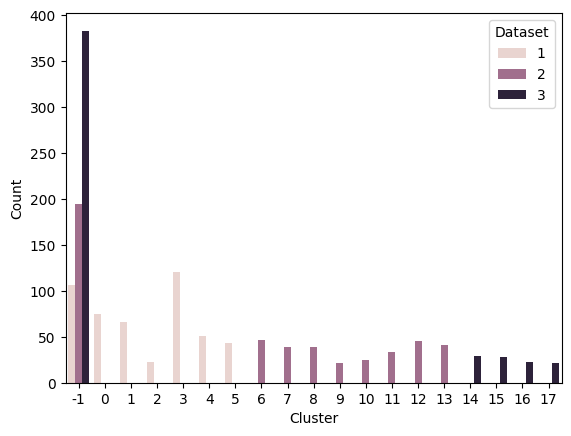

In [142]:
#Clusering using dbscan and mahalanobis distance
def inv(a):
    return np.linalg.inv(a)

def mahalanobis_distance(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    inv_covmat = inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal

import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

def cluster_dbscan_mahalanobis(file1,file2,file3):
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    
    #get prepared data
    X1,_,_,_ = GetPreparedData(data1,data1,prep_type=4)
    X2,_,_,_ = GetPreparedData(data2,data2,prep_type=4)
    X3,_,_,_ = GetPreparedData(data3,data3,prep_type=4)
    
    joined_data = pd.concat([X1,X2,X3],axis=0)
    print(joined_data.shape)
    #cluster this data
    cov = np.cov(joined_data.T)
    mahalanobis_dist = []
    for ind,row in joined_data.iterrows():
        mahalanobis_dist.append(mahalanobis_distance(row,joined_data,cov))
    mahalanobis_data = pd.DataFrame(mahalanobis_dist,columns=['Mahalanobis'])
    #Dataset column for 1 2 3
    mahalanobis_data['Dataset'] = 0
    mahalanobis_data.loc[0:X1.shape[0],'Dataset'] = 1
    mahalanobis_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    mahalanobis_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    
    #cluster this data
    dbscan = DBSCAN(eps=0.5, min_samples=20).fit(mahalanobis_data)
    #Label points vs dataset
    labels = dbscan.labels_
    #find number of points of X1,X2,X3 in each cluster
    dbscan_data = pd.DataFrame(labels,columns=['Cluster'])
    #Dataset column for 1 2 3
    dbscan_data['Dataset'] = 0
    dbscan_data.loc[0:X1.shape[0],'Dataset'] = 1
    dbscan_data.loc[X1.shape[0]:X1.shape[0]+X2.shape[0],'Dataset'] = 2
    dbscan_data.loc[X1.shape[0]+X2.shape[0]:,'Dataset'] = 3
    #join data1,2,3
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data3 = pd.read_csv(file3)
    joined_data = pd.concat([data1,data2,data3],axis=0)
    joined_data = joined_data.reset_index(drop=True)
    dbscan_data = dbscan_data.join(joined_data, how='outer')
    dbscan_data.to_csv('dbscan_mahalanobis_data.csv',index=False)
    
cluster_dbscan_mahalanobis('university1_c1.csv','university1_c2.csv','university1_c3.csv')
#Count of each cluster for each dataset
d_m_data = pd.read_csv('dbscan_mahalanobis_data.csv')
print(d_m_data.groupby(['Dataset','Cluster']).size())
m=d_m_data.groupby(['Dataset','Cluster']).size().reset_index(name='Count')
m.to_csv("DSCANMAH_CLUSTERvsDATASET.csv",index=False)
sns.barplot(x='Cluster',y='Count',hue='Dataset',data=m)
plt.savefig('dbscan_mahalanobis.png')
plt.show()



We can see there is not much overlap between each datasets and the clusters are well separated.. We can use this see the clumping of the points from added change 3 from change 2. They are well dispersed. It means the test data is good for the model to test and not biased towards the train data.

**Finding the Outliers**

In [130]:
def find_outliers(joined):
    outliers = joined[joined["Cluster"] == -1]
    outliers.to_csv('outliers.csv',index=False)

joined = pd.read_csv('dbscan_mahalanobis_data.csv')
find_outliers(joined)

****Clsutering Even the train data with Mahalanobis Distance****

{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'btech': 1, 'mtech': 2, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 81, 'off_rec': 41, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'grade_book': 102, 'std_mat': 61, 'ce': 1, 'accounts': 2, 'ece': 3, 'me': 4, 'cse': 5, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61, 'quiz': 22, 'dept_bud': 42, 'proj': 43}
(4032, 5)


C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


Cluster
-1      17
 0     144
 1      23
 2      48
 3      46
 4     204
 5     138
 6     408
 7     217
 8     144
 9     138
 10    156
 11    318
 12    276
 13     46
 14     71
 15     96
 16    468
 17    136
 18     48
 19     69
 20     92
 21     48
 22     48
 23    159
 24    106
 25     69
 26     32
 27     24
 28     53
 29     71
 30     24
 31     72
 32     23
dtype: int64


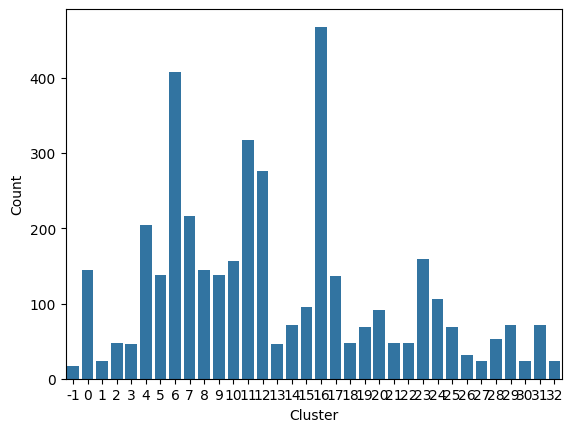

In [131]:

#Clusering using dbscan and mahalanobis distance
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

def cluster_dbscan_mahalanobis(file):
    
    train_data = pd.read_csv(file)
    train_data,_,_,_ = GetPreparedData(train_data,train_data,prep_type=4)
    print(train_data.shape)
    #cluster this data
    cov = np.cov(train_data.T)
    mahalanobis_dist = []
    for ind,row in train_data.iterrows():
        mahalanobis_dist.append(mahalanobis_distance(row,train_data,cov))
    mahalanobis_data = pd.DataFrame(mahalanobis_dist,columns=['Mahalanobis'])
    #Dataset column for 1 2 3
    
    
    #cluster this data
    dbscan = DBSCAN(eps=0.5, min_samples=20).fit(mahalanobis_data)
    #Label points vs dataset
    labels = dbscan.labels_
    #find number of points of X1,X2,X3 in each cluster
    dbscan_data = pd.DataFrame(labels,columns=['Cluster'])
    #Dataset column for 1 2 3
    train_data = pd.read_csv(file)
    train_data = train_data.reset_index(drop=True)
    dbscan_data = dbscan_data.join(train_data, how='outer')
    dbscan_data.to_csv('train_data_clustered.csv',index=False)
    
cluster_dbscan_mahalanobis('university_saptarshi_train.csv')
#Count of each cluster for each dataset
d_m_data = pd.read_csv('train_data_clustered.csv')
#Find per cluster count
print(d_m_data.groupby(['Cluster']).size())
m=d_m_data.groupby(['Cluster']).size().reset_index(name='Count')
sns.barplot(x='Cluster',y='Count',data=m)
plt.show()



We can see the data is not biased to one side and the data is well dispersed. We can see the outliers in the data which are very low in number.

****Finding the changes introduced in change 3 from change 2 misclassifications Such that they are being classified Correctly****

In [132]:
import pandas as pd
import numpy as np

linked_attr_univ1 = {
    "Year": "Year.1",
    "Designation": "Designation",
    "Department": "Department.1",
    "Degree": "Degree.1",
    "Type": "Type",
}

def find_changes(file1, file2):
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    
    #reset index
    data1.reset_index(drop=True, inplace=True)
    data2.reset_index(drop=True, inplace=True)
    data1,data2,_,_ = GetPreparedData(data1,data2,prep_type=1)
    print(data2)
    
    change = pd.DataFrame(columns=["Change"])
    
    for ind, row in data1.iterrows():
        for ind2, row2 in data2.iterrows():
            changes =0
            for attr in linked_attr_univ1:
                if row[attr] != row2[attr] or row[linked_attr_univ1[attr]] != row2[linked_attr_univ1[attr]]:
                    print(row[attr],row2[attr],row[linked_attr_univ1[attr]],row2[linked_attr_univ1[attr]])
                    if(changes==0):
                        changes = 1
                    else:
                        changes+=1
            print(changes)
            if(changes==1):
                for attr in linked_attr_univ1:
                    if row[attr] != row2[attr] or row[linked_attr_univ1[attr]] != row2[linked_attr_univ1[attr]]:
                        change = change._append(pd.DataFrame([f"{attr}"],columns=["Change"]))
    change.reset_index(drop=True, inplace=True)
    return change



change = find_changes('change2_misclassifications_4.csv','university1_c3.csv')

#join this with the original data
change = change.join(pd.read_csv('change2_misclassifications_4.csv'),how='outer')
change.to_csv('change2_change3.csv',index=False)


{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'stu': 1, 'vis_prof': 2, 'adj_prof': 3, 'officer': 4, 'prof': 5, 'chem': 1, 'eni': 2, 'pha': 3, 'IT': 4, 'me': 5, 'ece': 6, 'cse': 7, 'ce': 8, 'BE': 1, 'ME': 2, 'mtech': 3, '3': 1, '1': 2, '4': 3, '2': 4, 'attdn': 1, 'stu_rec': 2, 'grade_book': 3, 'std_mat': 4, 'dept_bud': 5, 'proj': 6, 'asgn': 7, 'quiz': 8, 'q_pr': 9, 'btech': 4}
     Designation  Department  Degree  Year  Type  Department.1  Degree.1  \
0              4           2       1    -1     5             2         1   
1              2           4       2     2     4             4         2   
2              2           3       1    -1     4             3         1   
3              3           3       1     2     4             3         1   
4              2           4       1     3     2             4         1   
..           ...         ...     ...   ...   ...           ...       ...   
479            3           3      -1    -1     9             1         2   
480            2     

C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)


1.0 1.0 4.0
1.0 7.0 1.0 7.0
5
2.0 -1.0 1.0 3.0
1.0 4.0 1.0 4.0
2.0 1.0 2.0 1.0
2.0 5.0 2.0 5.0
4
2.0 2.0 1.0 2.0
1.0 2.0 1.0 2.0
2.0 4.0 2.0 4.0
2.0 4.0 2.0 4.0
4
2.0 -1.0 1.0 2.0
1.0 2.0 1.0 2.0
2.0 3.0 2.0 3.0
2.0 1.0 2.0 1.0
2.0 4.0 2.0 4.0
5
2.0 2.0 1.0 2.0
1.0 3.0 1.0 3.0
2.0 3.0 2.0 3.0
2.0 1.0 2.0 1.0
2.0 4.0 2.0 4.0
5
2.0 3.0 1.0 3.0
1.0 2.0 1.0 2.0
2.0 4.0 2.0 4.0
2.0 1.0 2.0 1.0
4
2.0 -1.0 1.0 1.0
1.0 5.0 1.0 5.0
2.0 1.0 2.0 1.0
2.0 6.0 2.0 6.0
4
2.0 4.0 1.0 4.0
1.0 3.0 1.0 3.0
2.0 4.0 2.0 4.0
2.0 1.0 2.0 1.0
2.0 1.0 2.0 1.0
5
2.0 -1.0 1.0 1.0
1.0 3.0 1.0 3.0
2.0 7.0 2.0 7.0
3
2.0 3.0 1.0 3.0
2.0 3.0 2.0 3.0
2.0 1.0 2.0 1.0
2.0 5.0 2.0 5.0
4
2.0 -1.0 1.0 3.0
1.0 3.0 1.0 3.0
2.0 4.0 2.0 4.0
2.0 -1.0 2.0 4.0
2.0 8.0 2.0 8.0
5
2.0 2.0 1.0 2.0
2.0 4.0 2.0 4.0
2.0 1.0 2.0 1.0
2.0 5.0 2.0 5.0
4
2.0 -1.0 1.0 3.0
1.0 2.0 1.0 2.0
2.0 -1.0 2.0 4.0
2.0 6.0 2.0 6.0
4
2.0 -1.0 1.0 2.0
1.0 3.0 1.0 3.0
2.0 3.0 2.0 3.0
2.0 1.0 2.0 1.0
2.0 9.0 2.0 9.0
5
2.0 4.0 1.0 4.0
2.0 3.0 2.0 3.0
2.0 1.0

In [133]:
#find the cluster of misclassified points

mis = {}

def find_cluster(file1,file2):
    misclassified = pd.read_csv(file1)
    misclassified = misclassified.reset_index(drop=True)
    test_data = pd.read_csv(file2)
    test_data = test_data.reset_index(drop=True)
    #find type of columns in both
    real_columns = test_data.columns
    real_columns = real_columns.drop(['Cluster','Dataset'])
    for col in real_columns:
        if type(misclassified[col][0]) != type(test_data[col][0]):
            #Encode both to string
            misclassified[col] = misclassified[col].astype(str)
            test_data[col] = test_data[col].astype(str)
    
    #find and print cluster of misclassified points
    for ind,row in misclassified.iterrows():
        for ind2,row2 in test_data.iterrows():
            same = True
            for attr in real_columns:
                if row[attr] != row2[attr]:
                    # print(row[attr],row2[attr])
                    same = False
                    break
            if same:
                if row2['Cluster'] not in mis:
                    mis[row2['Cluster']] = 1
                else:
                    mis[row2['Cluster']] += 1
                break

find_cluster('change2_misclassifications_4.csv','dbscan_mahalanobis_data.csv')
print("-"*40)
find_cluster('change3_misclassifications_4.csv','dbscan_mahalanobis_data.csv')

----------------------------------------


{7: 39, -1: 60, 13: 15, 12: 25, 17: 6}
   Cluster  Misclassified
0        7             39
1       -1             60
2       13             15
3       12             25
4       17              6


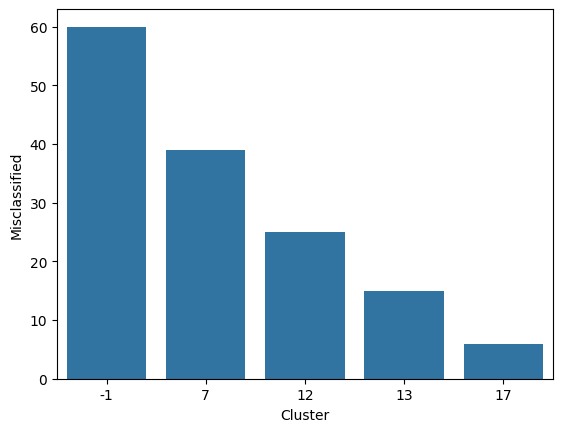

In [134]:
print(mis)
#make the =m int 
for key in mis:
    mis[key] = [mis[key]]
mis = pd.DataFrame.from_dict(mis)
mis = mis.T
mis.reset_index(drop=False, inplace=True)
mis.columns = ['Cluster','Misclassified']
print(mis)
mis.to_csv('misclassified_cluster.csv',index=False)

#plot the misclassified points
sns.barplot(x='Cluster',y='Misclassified',data=mis)
plt.savefig('misclassified_cluster_DT.png')
plt.show()
#Save the Plot



In [135]:


from numpy import rec
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

def do_testing(file_name,testfile,trainfile,pick=False):
    f = open(file_name+".csv", "w+")
    f.write('clf_name,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,accuracy,precision,recall,f1score,\n')
    f.close()

    if(True):
        name = "ArtificalNeuralNetwork"
        clf = MLPClassifier(hidden_layer_sizes=30, max_iter=1500,random_state=42)
        print(f"[INFO] Training model: {name}")
        f = open(file_name+".csv", "a+")
        f.write('%s,' % (name))
        f.close()

        for i in range(4,5): 
            print(i)
            
            train_data = pd.read_csv(trainfile)
            test_data = pd.read_csv(testfile)
            dataprep_start_time = time.time()
            X_train, X_test, y_train, y_test = GetPreparedData(train_data,test_data,prep_type=i)
            
            #print('Training the classifier')
            if(not pick):
                clf = clf.fit(X_train.to_numpy(), y_train.to_numpy())
            else:
                with open('ANN.pkl', 'rb') as f:
                    clf = pickle.load(f)
            
            pred = clf.predict(X_test.to_numpy())
            test_end_time = time.time()
            
            score(y_test.to_numpy(), pred, label=str(i),clfname=name,fname=file_name+".csv")
            pred_train = clf.predict(X_train.to_numpy())
            
            pred = pd.DataFrame(pred,columns=['Access'])
            
            #save DT to a figure
            from sklearn.tree import export_graphviz
            # print(type(X_test))
            misclass = find_misclassifications(y_test, pred, test_data, f'{file_name}_misclassifications_{i}_ANN.csv')
            #Make confusion matrix plot
            cm = confusion_matrix(y_test, pred)
            plt.figure(figsize=(10,7))
            sns.heatmap(cm, annot=True, fmt="d")
            plt.xlabel('Predicted')
            plt.ylabel('Truth')
            plt.title('Confusion Matrix')
            #make it color only leaf nodes
            
            #make tree to json
            
            #pickle this model
            with open(f'ANN.pkl', 'wb') as f:
                pickle.dump(clf, f)

[INFO] Training model: ArtificalNeuralNetwork
4
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'btech': 1, 'mtech': 2, 'BE': 3, 'ME': 4, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 81, 'off_rec': 41, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'grade_book': 102, 'std_mat': 61, 'proj': 43, 'dept_bud': 42, 'quiz': 22, 'ce': 1, 'accounts': 2, 'ece': 3, 'me': 4, 'cse': 5, 'chem': 6, 'eni': 7, 'IT': 8, 'pha': 9, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61}


C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4:
accuracy: 1.00
precision: 1.00
recall: 1.00
fscore: 1.00



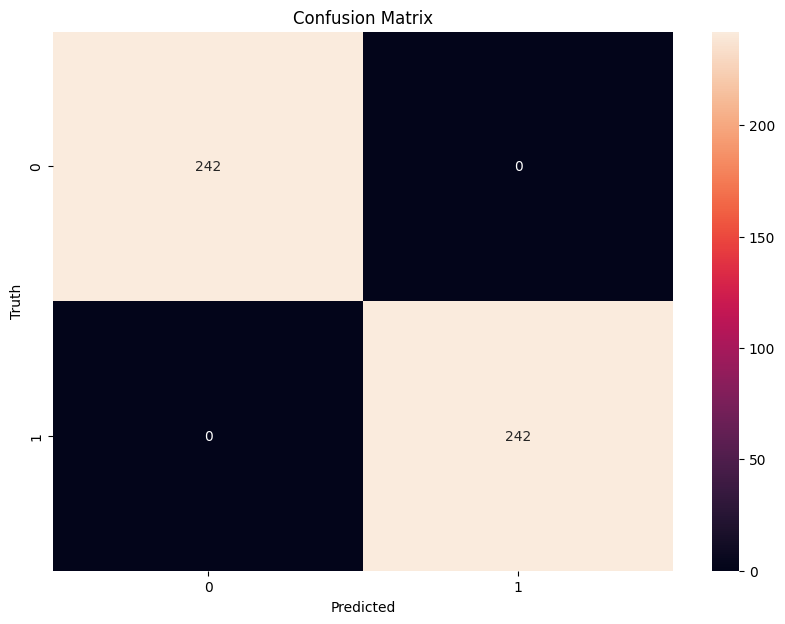

In [136]:
do_testing('change1','university1_c1.csv','university_saptarshi_train.csv')
#three msiclassifications

[INFO] Training model: ArtificalNeuralNetwork
4
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'btech': 1, 'mtech': 2, 'BE': 3, 'ME': 4, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 81, 'off_rec': 41, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'grade_book': 102, 'std_mat': 61, 'quiz': 22, 'proj': 43, 'dept_bud': 42, 'ce': 1, 'accounts': 2, 'ece': 3, 'me': 4, 'cse': 5, 'chem': 6, 'pha': 7, 'eni': 8, 'IT': 9, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61}


C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4:
accuracy: 0.81
precision: 0.83
recall: 0.79
fscore: 0.81



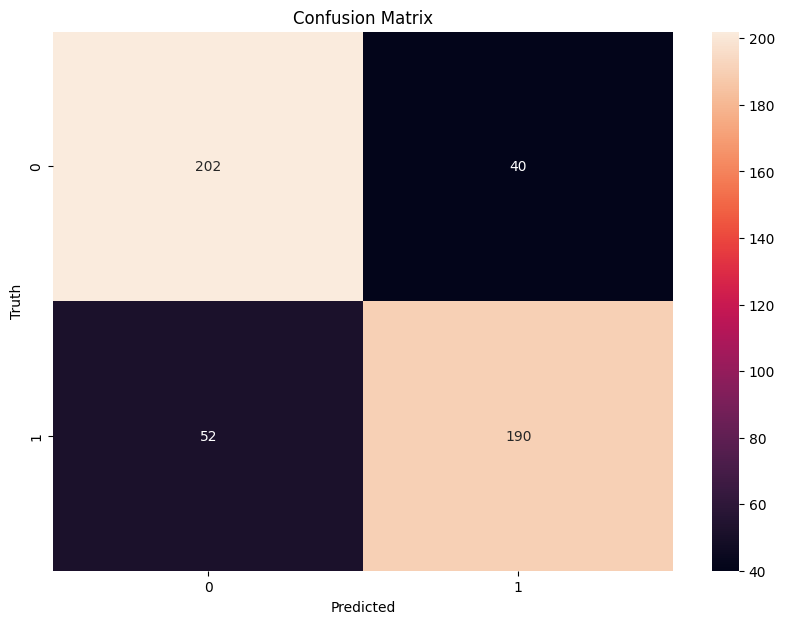

In [137]:
do_testing('change2','university1_c2.csv','university_saptarshi_train.csv',False)


[INFO] Training model: ArtificalNeuralNetwork
4
{'NotA': -1, 0: 0, 'Yes': 1, 'No': 0, 'btech': 1, 'mtech': 2, 'BE': 3, 'ME': 4, '2': 1, '4': 2, '1': 3, '3': 4, 'attdn': 81, 'off_rec': 41, 'asgn': 21, 'q_pr': 101, 'stu_rec': 82, 'grade_book': 102, 'std_mat': 61, 'dept_bud': 42, 'proj': 43, 'quiz': 22, 'ce': 1, 'accounts': 2, 'ece': 3, 'me': 4, 'cse': 5, 'eni': 6, 'IT': 7, 'pha': 8, 'chem': 9, 'officer': 21, 'prof': 41, 'adj_prof': 42, 'vis_prof': 43, 'stu': 61}


C:\Users\tipsh\AppData\Local\Temp\ipykernel_21584\1355176860.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = data.replace(mapping)
C:\Users\tipsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


4:
accuracy: 0.80
precision: 0.93
recall: 0.65
fscore: 0.77



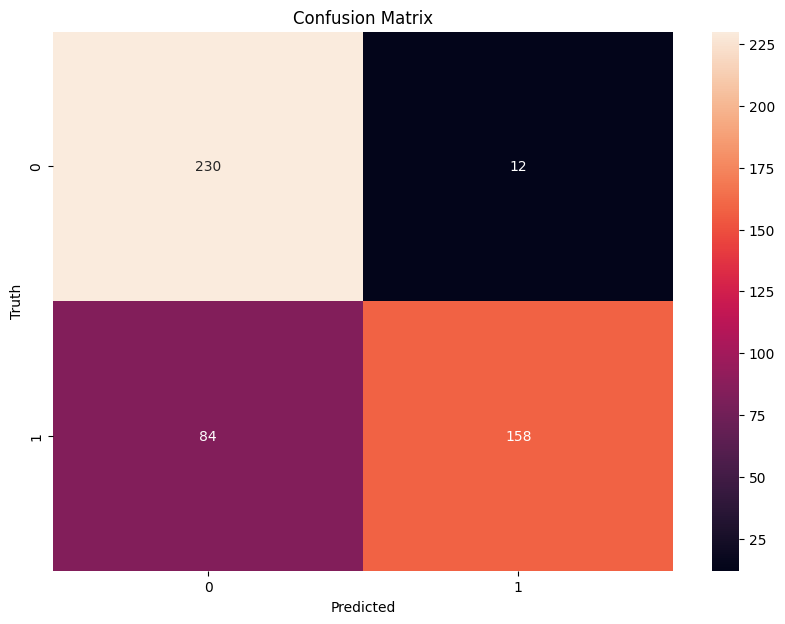

In [138]:
do_testing('change3','university1_c3.csv','university_saptarshi_train.csv',False)

In [139]:
#find the cluster of misclassified points

mis = {}

def find_cluster(file1,file2):
    misclassified = pd.read_csv(file1)
    misclassified = misclassified.reset_index(drop=True)
    test_data = pd.read_csv(file2)
    test_data = test_data.reset_index(drop=True)
    #find type of columns in both
    real_columns = test_data.columns
    real_columns = real_columns.drop(['Cluster','Dataset'])
    for col in real_columns:
        if type(misclassified[col][0]) != type(test_data[col][0]):
            #Encode both to string
            misclassified[col] = misclassified[col].astype(str)
            test_data[col] = test_data[col].astype(str)
    
    #find and print cluster of misclassified points
    for ind,row in misclassified.iterrows():
        for ind2,row2 in test_data.iterrows():
            same = True
            for attr in real_columns:
                if row[attr] != row2[attr]:
                    # print(row[attr],row2[attr])
                    same = False
                    break
            if same:
                if row2['Cluster'] not in mis:
                    mis[row2['Cluster']] = 1
                else:
                    mis[row2['Cluster']] += 1
                break

find_cluster('change2_misclassifications_4_ANN.csv','dbscan_mahalanobis_data.csv')
print("-"*40)
find_cluster('change3_misclassifications_4_ANN.csv','dbscan_mahalanobis_data.csv')

----------------------------------------


{7: 39, -1: 75, 13: 15, 12: 25, 15: 28, 17: 6}
   Cluster  Misclassified
0        7             39
1       -1             75
2       13             15
3       12             25
4       15             28
5       17              6


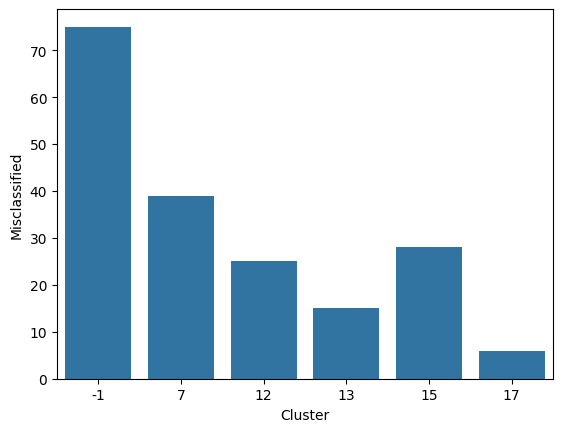

In [140]:
print(mis)
#make the =m int 
for key in mis:
    mis[key] = [mis[key]]
mis = pd.DataFrame.from_dict(mis)
mis = mis.T
mis.reset_index(drop=False, inplace=True)
mis.columns = ['Cluster','Misclassified']
print(mis)
mis.to_csv('misclassified_cluster_ANN.csv',index=False)

#plot the misclassified points
sns.barplot(x='Cluster',y='Misclassified',data=mis)
plt.savefig('misclassified_cluster_ANN.png')
plt.show()
#Save the Plot


